In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Problem2.1

Is Linear SVM a special case of Kernel SVM?

Yes! Although we can train Linear SVM directly via the formula: $y_{pred} = sgn(W*X_{test} + b)$, we can regard it as a special case of Kernel SVM by deriving the formula into the one of the dual problem $y_{pred} = αy_{train}X_{train}X_{test}^T + b$, while the same formula for Kernel SVM is $y_{pred} = αy_{train}K(X_{train},X_{test}) + b$. Then, it's very clear that Linear SVM is a special case of Kernel SVM

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

seed = 760

Linear SVM Implement

In [22]:
from ssl import RAND_status
class SVM:
  def __init__(self, C=1.0):
    self.C = C
    self.W = None
    self.b = None

  def fit(self, X:torch.tensor, y:torch.tensor, lr=0.005, num_epochs=2000):
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=250)
    num_samples, num_features = X_train.shape

    self.W = torch.randn(num_features, requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)
    self.X_train = X_train
    self.y_train = y_train

    for epoch in range(num_epochs):
        y_pred = self.predict(X_train)

        loss = self.hinge_loss(y_pred, y_train)

        self.W.grad = None
        self.b.grad = None

        loss.backward()

        with torch.no_grad():
            self.W -= lr * self.W.grad
            self.b -= lr * self.b.grad

        if (epoch + 1) % 100 == 0:
          y_valpred = self.predict(X_val)
          val_loss = self.hinge_loss(y_valpred, y_val)
          print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

  def hinge_loss(self, y_pred, y_true):
    loss = torch.mean(torch.clamp(1 - y_true * y_pred, min=0))
    loss += 0.5 * self.C * torch.sum(self.W**2)
    return loss

  def predict(self, X):
    if X.dtype != torch.float32:
      X = X.to(torch.float32)
    return torch.sign(torch.matmul(X, self.W) + self.b)

  def bound_visual(self):
    xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    Z = self.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), cmap = plt.cm.plasma, alpha=0.5)
    plt.scatter(x=self.X_train[:,0], y=self.X_train[:,1], c = (self.y_train-0.5), s = 5)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.show()

Kernel SVM Implement

In [34]:
class Kernel_SVM(nn.Module):
  def __init__(self, kernel='linear', degree=3, gamma=1.0, poly=1.0):
    super(Kernel_SVM, self).__init__()
    self.kernel = kernel
    self.degree = degree
    self.gamma = gamma
    self.poly = poly
    self.alpha = None
    self.bias = None
    self.X_train = None
    

  def forward(self, X):
    kernel_matrix = self.get_kernel(X)
    output = torch.matmul(self.alpha, kernel_matrix) + self.bias  
    return output


  def get_kernel(self, X):
    if self.X_train == None:
      raise ValueError('Invalid trainning')
    elif self.kernel == 'linear':
      kernel_matrix = torch.matmul(self.X_train, X.t())  # linear
    elif self.kernel == 'rbf':
      dist = torch.cdist(self.X_train, X, p=2)
      kernel_matrix = torch.exp(-self.gamma*dist)  # RBF 
    elif self.kernel == 'polynomial':
      kernel_matrix = (torch.matmul(self.X_train, X.t()) + self.poly) ** self.degree  # poly
    else:
      raise ValueError('Invalid kernel type')
    
    return kernel_matrix

  def fit(self, X, y, num_epochs=2000, lr=0.005):
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=250)
    num_samples, num_features = X_train.shape

    # initializaiton
    self.alpha = nn.Parameter(torch.randn(num_samples))
    self.bias = nn.Parameter(torch.zeros(1))
    self.X_train = X_train
    self.y_train = y_train

    optimizer = optim.SGD(self.parameters(), lr=lr)  # SGD optimizer
    loss_fn = nn.HingeEmbeddingLoss()

    for epoch in range(num_epochs):
      optimizer.zero_grad()
      output = self.forward(X_train)
      loss = loss_fn(output * y_train.unsqueeze(1), torch.ones_like(output))  # construct loss function
      loss.backward()
      optimizer.step() 

      if (epoch + 1) % 100 == 0:
        y_valpred = self.predict(X_val)
        val_loss = loss_fn(y_valpred * y_val.unsqueeze(1), torch.ones_like(y_valpred))
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

  def predict(self,X):
    if X.dtype != torch.float32:
      X = X.to(torch.float32)
    f = torch.sign(self.forward(X))
    return f
  
  def bound_visual(self):
    xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    Z = self.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), cmap = plt.cm.plasma, alpha=0.5)
    plt.scatter(x=self.X_train[:,0], y=self.X_train[:,1], c = (self.y_train-0.5), s = 5)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.show()

Logistic Regression Implement

In [28]:
class Logistic_Regression(nn.Module):
  def __init__(self):
    super(Logistic_Regression, self).__init__()
    self.theta = None
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    if self.theta == None:
      raise ValueError('Invalid theta')
    
    return self.sigmoid(self.theta(X)) 

  def fit(self, X, y, num_epochs=1000, lr=0.01): 
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=250)
    y_train = y_train.unsqueeze(1)
    y_val = y_val.unsqueeze(1)

    self.X_train = X_train
    self.y_train = y_train
    
    self.theta = nn.Linear(X.shape[1],1)
    optimizer = optim.SGD(self.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
      optimizer.zero_grad()
      output = self.forward(X_train)
      loss = criterion(output, y_train)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
        y_valpred = self.forward(X_val)
        val_loss = criterion(y_valpred, y_val)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')


  def loss_fn(self, y_pred, y):
    e = 1e-8
    y_pred = torch.clamp(y_pred, e, 1-e)
    loss = y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)
    return torch.sum(loss)

  def predict(self, X):
    if X.dtype != torch.float32:
      X = X.to(torch.float32)
    return torch.round(self.forward(X))

  def bound_visual(self):
    xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    Z = self.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), cmap = plt.cm.plasma, alpha=0.5)
    plt.scatter(x=self.X_train[:,0], y=self.X_train[:,1], c = (self.y_train-0.5), s = 5)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.show()

Kernel Logistic Regression Implement

In [118]:
class Kernel_Logistic_Regression(nn.Module):
  def __init__(self):
    super(Kernel_Logistic_Regression, self).__init__()
    self.theta = None
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    if self.theta == None:
      raise ValueError('Invalid theta')
    if X.dtype != torch.float32:
      X = X.to(torch.float32)

    kernel_matrix = torch.ones(self.X_train.shape[0],X.shape[0])

    for j in range(0,X.shape[0]):
      for i in range(0,self.X_train.shape[0]):
        if torch.equal(X[i,:],self.X_train[j,:]):
          kernel_matrix[i,j] = 1
        else:
          kernel_matrix[i,j] = 0
    kernel_matrix = kernel_matrix.to(torch.float32)
    return self.sigmoid(self.theta(kernel_matrix)) 

  def fit(self, X, y, num_epochs=1000, lr=0.01): 
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=250)
    y_train = y_train.unsqueeze(1)
    y_val = y_val.unsqueeze(1)

    self.X_train = X_train
    self.y_train = y_train
    
    self.theta = nn.Linear(X_train.shape[0],1)
    optimizer = optim.SGD(self.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
      optimizer.zero_grad()
      output = self.forward(X_train)
      loss = criterion(output, y_train)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
        y_valpred = self.forward(X_val)
        val_loss = criterion(y_valpred, y_val)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')


  def loss_fn(self, y_pred, y):
    e = 1e-8
    y_pred = torch.clamp(y_pred, e, 1-e)
    loss = y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)
    return torch.sum(loss)

  def predict(self, X):
    return torch.round(self.forward(X))

  def bound_visual(self):
    xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    Z = self.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), cmap = plt.cm.plasma, alpha=0.5)
    plt.scatter(x=self.X_train[:,0], y=self.X_train[:,1], c = (self.y_train-0.5), s = 5)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.show()

In [109]:
a = torch.tensor([[1,2],[2,3],[1,3]])
b = torch.tensor([[1,3],[2,3]])
a[1,1]

tensor(3)

Generate synthetic dataset

In [ ]:
def generate_data(mu, num_points=750):
  mean = torch.tensor([mu,mu]).to(torch.float)
  sigma = torch.tensor([[1.0,0.0],[0.0,1.0]])

  mvn = torch.distributions.MultivariateNormal(mean,sigma)
  data = mvn.sample((num_points,))
  label = torch.sign(torch.tensor(mu))*torch.ones(num_points)
  return data,label

### 2.2.1

In [ ]:
data1,y1 = generate_data(mu=2)
data2,y2 = generate_data(mu=-2)
X = torch.cat((data1,data2),dim=0)
y = torch.cat((y1,y2),dim=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=250)


svm_model = SVM()
svm_model.fit(X=X_train,y=y_train)
y_pred = svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/2000], Validation Loss: 2.2067
Epoch [200/2000], Validation Loss: 0.8148
Epoch [300/2000], Validation Loss: 0.3041
Epoch [400/2000], Validation Loss: 0.1166
Epoch [500/2000], Validation Loss: 0.0479
Epoch [600/2000], Validation Loss: 0.0226
Epoch [700/2000], Validation Loss: 0.0134
Epoch [800/2000], Validation Loss: 0.0100
Epoch [900/2000], Validation Loss: 0.0087
Epoch [1000/2000], Validation Loss: 0.0083
Epoch [1100/2000], Validation Loss: 0.0081
Epoch [1200/2000], Validation Loss: 0.0080
Epoch [1300/2000], Validation Loss: 0.0080
Epoch [1400/2000], Validation Loss: 0.0080
Epoch [1500/2000], Validation Loss: 0.0080
Epoch [1600/2000], Validation Loss: 0.0080
Epoch [1700/2000], Validation Loss: 0.0080
Epoch [1800/2000], Validation Loss: 0.0080
Epoch [1900/2000], Validation Loss: 0.0080
Epoch [2000/2000], Validation Loss: 0.0080
0.988


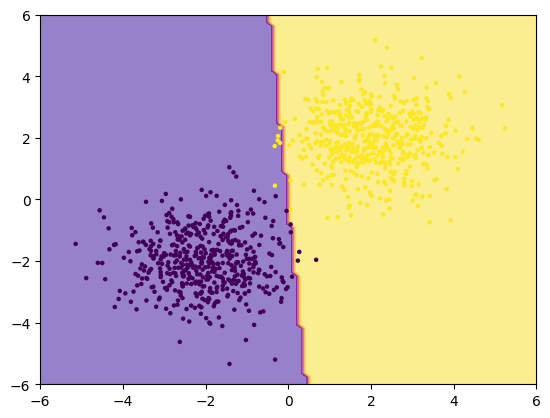

In [ ]:
svm_model.bound_visual()

In [ ]:
lr_model = Logistic_Regression()
lr_model.fit(X=X_train,y=y_train)
y_pred = torch.sgn(lr_model.predict(X_test)-0.5)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/1000], Validation Loss: -2.9062
Epoch [200/1000], Validation Loss: -5.2155
Epoch [300/1000], Validation Loss: -7.4781
Epoch [400/1000], Validation Loss: -9.6732
Epoch [500/1000], Validation Loss: -11.5295
Epoch [600/1000], Validation Loss: -12.8962
Epoch [700/1000], Validation Loss: -13.9215
Epoch [800/1000], Validation Loss: -14.7499
Epoch [900/1000], Validation Loss: -15.4451
Epoch [1000/1000], Validation Loss: -16.0504
0.996


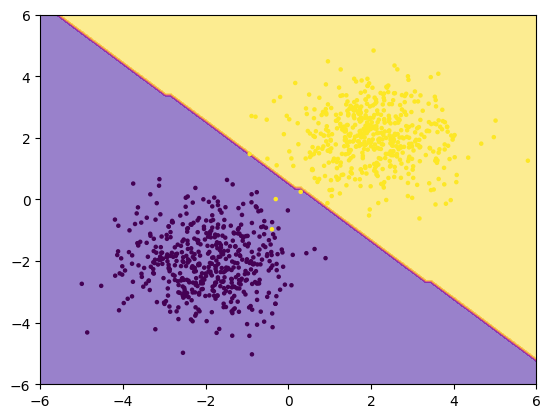

In [ ]:
lr_model.bound_visual()

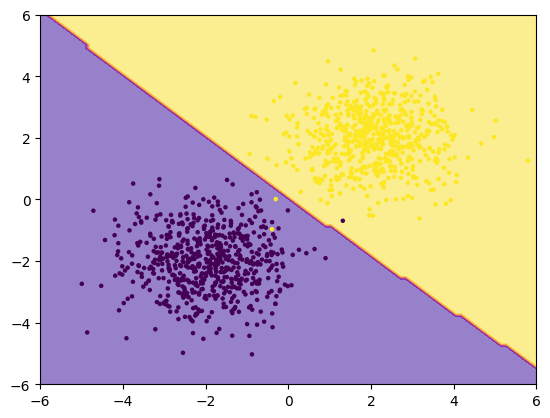

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
Z = gnb.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
Z = Z.reshape(xx.shape)

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z, cmap = plt.cm.plasma, alpha=0.5)
plt.scatter(x=X_train[:,0], y=X_train[:,1], c = (y_train-0.5), s = 5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

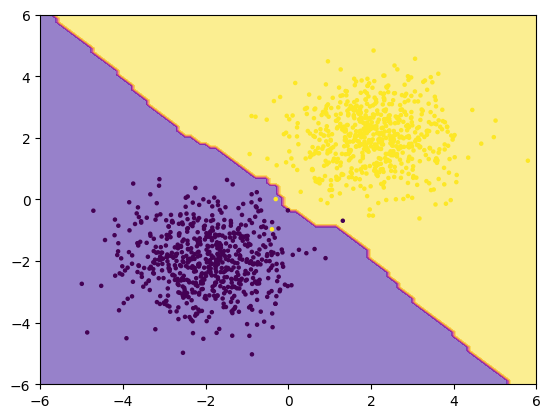

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
Z = knn.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
Z = Z.reshape(xx.shape)

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z, cmap = plt.cm.plasma, alpha=0.5)
plt.scatter(x=X_train[:,0], y=X_train[:,1], c = (y_train-0.5), s = 5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

In [ ]:
linear_svm_acc = []
linear_kernel_svm_acc = []
lr_acc = []
knn_acc = []
nb_acc = []
us = np.arange(1,2.4,0.2)
for u in us:
  data1,y1 = generate_data(mu=u)
  data2,y2 = generate_data(mu=-u)
  X = torch.cat((data1,data2),dim=0)
  y = torch.cat((y1,y2),dim=0)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=250)

  ### linear svm
  svm_model = SVM()
  svm_model.fit(X=X_train,y=y_train)
  y_pred = svm_model.predict(X_test)
  linear_svm_acc.append(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

  ### linear svm with kernel
  svm_model = Kernel_SVM(kernel="linear")
  svm_model.fit(X=X_train,y=y_train)
  y_pred = svm_model.predict(X_test)
  linear_kernel_svm_acc.append(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))


  ### logistic regression
  lr_model = Logistic_Regression()
  lr_model.fit(X=X_train,y=y_train)
  y_pred = torch.sign(lr_model.predict(X_test)-0.5)
  lr_acc.append(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

  ### knn
  knn = KNeighborsClassifier(n_neighbors=3)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  knn_acc.append(accuracy_score(y_test, y_pred))

  ### nb
  gnb = GaussianNB()
  gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  nb_acc.append(accuracy_score(y_test, y_pred))

Epoch [100/2000], Validation Loss: 1.8306
Epoch [200/2000], Validation Loss: 1.7961
Epoch [300/2000], Validation Loss: 1.7834
Epoch [400/2000], Validation Loss: 1.7787
Epoch [500/2000], Validation Loss: 1.7770
Epoch [600/2000], Validation Loss: 1.7764
Epoch [700/2000], Validation Loss: 1.7761
Epoch [800/2000], Validation Loss: 1.7760
Epoch [900/2000], Validation Loss: 1.7760
Epoch [1000/2000], Validation Loss: 1.7760
Epoch [1100/2000], Validation Loss: 1.7760
Epoch [1200/2000], Validation Loss: 1.7760
Epoch [1300/2000], Validation Loss: 1.7760
Epoch [1400/2000], Validation Loss: 1.7760
Epoch [1500/2000], Validation Loss: 1.7760
Epoch [1600/2000], Validation Loss: 1.7760
Epoch [1700/2000], Validation Loss: 1.7760
Epoch [1800/2000], Validation Loss: 1.7760
Epoch [1900/2000], Validation Loss: 1.7760
Epoch [2000/2000], Validation Loss: 1.7760
Epoch [100/2000], Validation Loss: -0.0001
Epoch [200/2000], Validation Loss: -0.0001
Epoch [300/2000], Validation Loss: 0.0004
Epoch [400/2000], Val

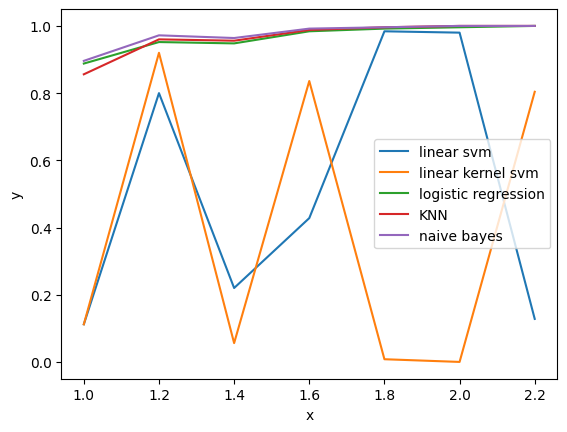

In [ ]:
plt.plot(us,linear_svm_acc,label="linear svm")
plt.plot(us,linear_kernel_svm_acc,label="linear kernel svm")
plt.plot(us,lr_acc,label="logistic regression")
plt.plot(us,knn_acc,label="KNN")
plt.plot(us,nb_acc,label="naive bayes")

plt.legend()

plt.xlabel('x')
plt.ylabel('y')

plt.show()

Conclusion:

For knn, naive beyas and logistic regression, they performed prety well on this simply data set. However, the performance of linear svm was sometimes good but much more unstable even after I tried several combination of hyperparameters and added the number of epoches.

###2.2.2

In [56]:
from sklearn.datasets import make_circles
circles = make_circles(n_samples=1500)
X_train, X_test, y_train, y_test = train_test_split(circles[0], circles[1], test_size=250)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

svm_model = SVM()
svm_model.fit(X=X_train,y=y_train)
y_pred = svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/2000], Validation Loss: 1.1241
Epoch [200/2000], Validation Loss: 0.9645
Epoch [300/2000], Validation Loss: 0.9059
Epoch [400/2000], Validation Loss: 0.8845
Epoch [500/2000], Validation Loss: 0.8766
Epoch [600/2000], Validation Loss: 0.8737
Epoch [700/2000], Validation Loss: 0.8726
Epoch [800/2000], Validation Loss: 0.8722
Epoch [900/2000], Validation Loss: 0.8721
Epoch [1000/2000], Validation Loss: 0.8720
Epoch [1100/2000], Validation Loss: 0.8720
Epoch [1200/2000], Validation Loss: 0.8720
Epoch [1300/2000], Validation Loss: 0.8720
Epoch [1400/2000], Validation Loss: 0.8720
Epoch [1500/2000], Validation Loss: 0.8720
Epoch [1600/2000], Validation Loss: 0.8720
Epoch [1700/2000], Validation Loss: 0.8720
Epoch [1800/2000], Validation Loss: 0.8720
Epoch [1900/2000], Validation Loss: 0.8720
Epoch [2000/2000], Validation Loss: 0.8720
0.248


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


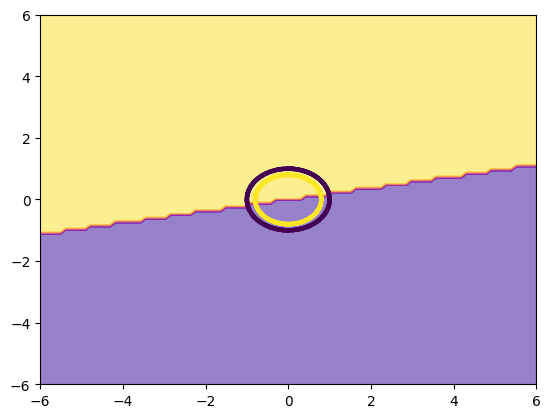

In [26]:
svm_model.bound_visual()

In [29]:
lr_model = Logistic_Regression()
lr_model.fit(X=X_train,y=y_train)
y_pred = torch.sgn(lr_model.predict(X_test)-0.5)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/1000], Validation Loss: 0.7450
Epoch [200/1000], Validation Loss: 0.7338
Epoch [300/1000], Validation Loss: 0.7257
Epoch [400/1000], Validation Loss: 0.7199
Epoch [500/1000], Validation Loss: 0.7155
Epoch [600/1000], Validation Loss: 0.7122
Epoch [700/1000], Validation Loss: 0.7096
Epoch [800/1000], Validation Loss: 0.7075
Epoch [900/1000], Validation Loss: 0.7059
Epoch [1000/1000], Validation Loss: 0.7045
0.184


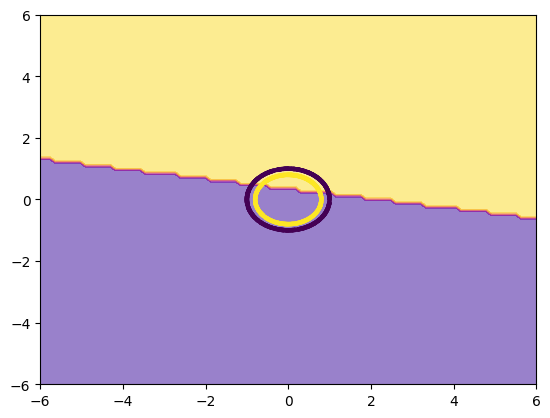

In [30]:
lr_model.bound_visual()

In [131]:
kernel_svm_y_train = y_train*2-1
kernel_svm_y_test = y_test*2-1
kernel_svm_model = Kernel_SVM(kernel="rbf",gamma = 10)
kernel_svm_model.fit(X=X_train,y=kernel_svm_y_train, num_epochs=5000)
y_pred = kernel_svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),kernel_svm_y_test.numpy()))

Epoch [100/5000], Validation Loss: -0.0323
Epoch [200/5000], Validation Loss: -0.0323
Epoch [300/5000], Validation Loss: -0.0323
Epoch [400/5000], Validation Loss: -0.0323
Epoch [500/5000], Validation Loss: -0.0323
Epoch [600/5000], Validation Loss: -0.0317
Epoch [700/5000], Validation Loss: -0.0311
Epoch [800/5000], Validation Loss: -0.0305
Epoch [900/5000], Validation Loss: -0.0294
Epoch [1000/5000], Validation Loss: -0.0294
Epoch [1100/5000], Validation Loss: -0.0294
Epoch [1200/5000], Validation Loss: -0.0294
Epoch [1300/5000], Validation Loss: -0.0282
Epoch [1400/5000], Validation Loss: -0.0276
Epoch [1500/5000], Validation Loss: -0.0271
Epoch [1600/5000], Validation Loss: -0.0265
Epoch [1700/5000], Validation Loss: -0.0265
Epoch [1800/5000], Validation Loss: -0.0242
Epoch [1900/5000], Validation Loss: -0.0242
Epoch [2000/5000], Validation Loss: -0.0242
Epoch [2100/5000], Validation Loss: -0.0242
Epoch [2200/5000], Validation Loss: -0.0242
Epoch [2300/5000], Validation Loss: -0.02

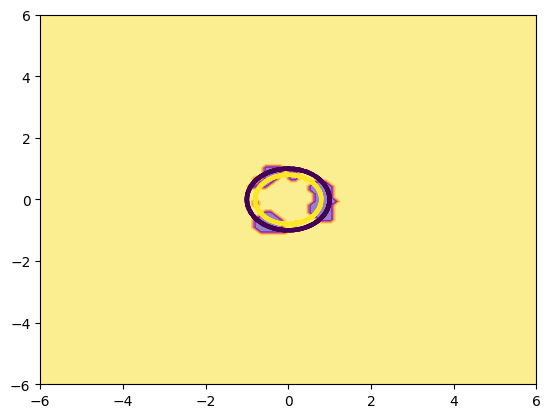

In [132]:
kernel_svm_model.bound_visual()

In [129]:
kernel_svm_y_train = y_train*2-1
kernel_svm_y_test = y_test*2-1
kernel_svm_model = Kernel_SVM(kernel="polynomial", degree = 10)
kernel_svm_model.fit(X=X_train,y=kernel_svm_y_train)
y_pred = kernel_svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),kernel_svm_y_test.numpy()))

Epoch [100/2000], Validation Loss: -0.0579
Epoch [200/2000], Validation Loss: -0.0640
Epoch [300/2000], Validation Loss: -0.0640
Epoch [400/2000], Validation Loss: -0.0640
Epoch [500/2000], Validation Loss: -0.0640
Epoch [600/2000], Validation Loss: -0.0640
Epoch [700/2000], Validation Loss: -0.0640
Epoch [800/2000], Validation Loss: -0.0640
Epoch [900/2000], Validation Loss: -0.0640
Epoch [1000/2000], Validation Loss: -0.0640
Epoch [1100/2000], Validation Loss: -0.0640
Epoch [1200/2000], Validation Loss: -0.0640
Epoch [1300/2000], Validation Loss: -0.0640
Epoch [1400/2000], Validation Loss: -0.0640
Epoch [1500/2000], Validation Loss: -0.0640
Epoch [1600/2000], Validation Loss: -0.0640
Epoch [1700/2000], Validation Loss: -0.0640
Epoch [1800/2000], Validation Loss: -0.0640
Epoch [1900/2000], Validation Loss: -0.0640
Epoch [2000/2000], Validation Loss: -0.0640
0.536


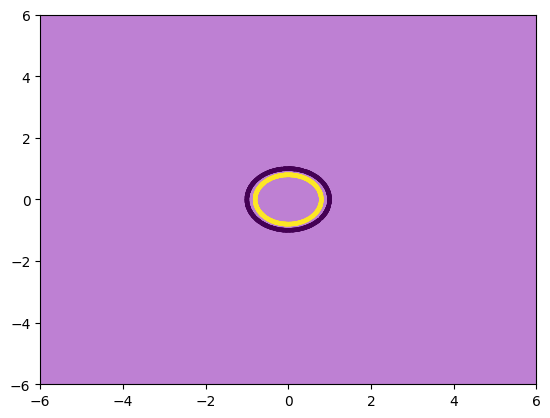

In [125]:
kernel_svm_model.bound_visual()

KNN and neutal network

In [143]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


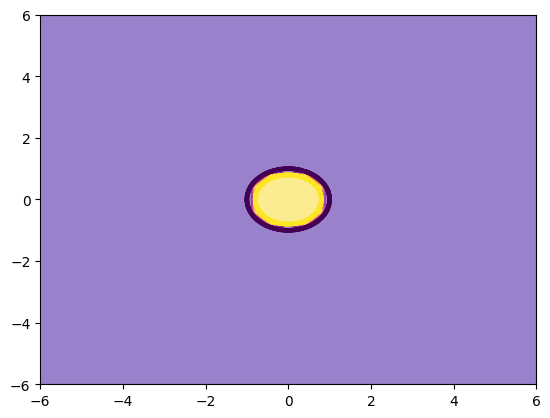

In [144]:
xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
Z = knn.predict(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1))
Z = Z.reshape(xx.shape)

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z, cmap = plt.cm.plasma, alpha=0.5)
plt.scatter(x=X_train[:,0], y=X_train[:,1], c = (y_train-0.5), s = 5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

In [248]:
def train_neural_network(X, y, num_epochs=1000, lr=0.01): 
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=250)
    y_train = y_train.unsqueeze(1)
    y_val = y_val.unsqueeze(1)

    model = nn.Sequential(
      nn.Linear(in_features = X_train.shape[1], out_features = 300),
      nn.Sigmoid(),
      nn.Linear(in_features = 300, out_features = 200),
      nn.Sigmoid(),
      nn.Linear(in_features = 200, out_features = 1),
      nn.Sigmoid()
    )

    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_valpred = model(X_val)
            val_loss = criterion(y_valpred, y_val)

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}')

    return model

In [209]:
my_nn= train_neural_network(X_train,y_train,num_epochs=3000)
nn_X_test = X_test.to(torch.float32)
y_pred = torch.round(my_nn(nn_X_test))
print(accuracy_score(y_test, y_pred.detach().numpy()))

Epoch [100/3000], Val Loss: 0.6932
Epoch [200/3000], Val Loss: 0.6932
Epoch [300/3000], Val Loss: 0.6932
Epoch [400/3000], Val Loss: 0.6933
Epoch [500/3000], Val Loss: 0.6933
Epoch [600/3000], Val Loss: 0.6933
Epoch [700/3000], Val Loss: 0.6933
Epoch [800/3000], Val Loss: 0.6933
Epoch [900/3000], Val Loss: 0.6934
Epoch [1000/3000], Val Loss: 0.6934
Epoch [1100/3000], Val Loss: 0.6934
Epoch [1200/3000], Val Loss: 0.6934
Epoch [1300/3000], Val Loss: 0.6934
Epoch [1400/3000], Val Loss: 0.6935
Epoch [1500/3000], Val Loss: 0.6935
Epoch [1600/3000], Val Loss: 0.6935
Epoch [1700/3000], Val Loss: 0.6935
Epoch [1800/3000], Val Loss: 0.6935
Epoch [1900/3000], Val Loss: 0.6936
Epoch [2000/3000], Val Loss: 0.6936
Epoch [2100/3000], Val Loss: 0.6936
Epoch [2200/3000], Val Loss: 0.6936
Epoch [2300/3000], Val Loss: 0.6936
Epoch [2400/3000], Val Loss: 0.6937
Epoch [2500/3000], Val Loss: 0.6937
Epoch [2600/3000], Val Loss: 0.6937
Epoch [2700/3000], Val Loss: 0.6937
Epoch [2800/3000], Val Loss: 0.6937
E

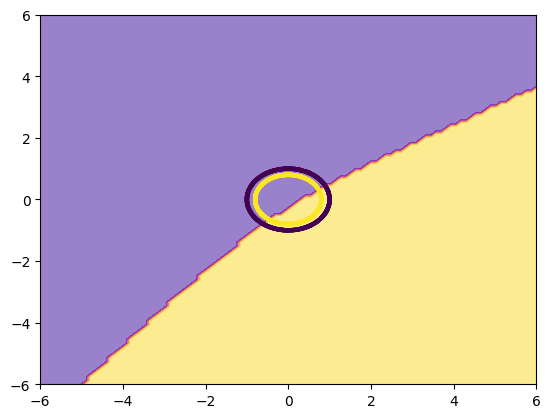

In [210]:
xx, yy = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
Z = torch.round(my_nn(torch.cat((xx.reshape(-1,1),yy.reshape(-1,1)),dim=1)))
Z = Z.reshape(xx.shape)

plt.contourf(xx.detach().numpy(), yy.detach().numpy(), Z.detach().numpy(), cmap = plt.cm.plasma, alpha=0.5)
plt.scatter(x=X_train[:,0], y=X_train[:,1], c = (y_train-0.5), s = 5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

In [130]:
kernel_lr = Kernel_Logistic_Regression()
kernel_lr.fit(X_train,y_train)
y_pred = kernel_lr.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),kernel_svm_y_test.numpy()))

KeyboardInterrupt: ignored

### 2.2.3

In [239]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
data = torch.tensor(dataset["data"])
data = torch.nn.functional.normalize(data)
labels = dataset["target"]
labels = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=250)

In [240]:
svm_model = SVM()
svm_model.fit(X=X_train,y=y_train)
y_pred = svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/2000], Validation Loss: 5.7847
Epoch [200/2000], Validation Loss: 2.3633
Epoch [300/2000], Validation Loss: 1.1078
Epoch [400/2000], Validation Loss: 0.6471
Epoch [500/2000], Validation Loss: 0.4780
Epoch [600/2000], Validation Loss: 0.4160
Epoch [700/2000], Validation Loss: 0.3932
Epoch [800/2000], Validation Loss: 0.3848
Epoch [900/2000], Validation Loss: 0.3818
Epoch [1000/2000], Validation Loss: 0.3807
Epoch [1100/2000], Validation Loss: 0.3802
Epoch [1200/2000], Validation Loss: 0.3801
Epoch [1300/2000], Validation Loss: 0.3800
Epoch [1400/2000], Validation Loss: 0.3800
Epoch [1500/2000], Validation Loss: 0.3800
Epoch [1600/2000], Validation Loss: 0.3800
Epoch [1700/2000], Validation Loss: 0.3800
Epoch [1800/2000], Validation Loss: 0.3800
Epoch [1900/2000], Validation Loss: 0.3800
Epoch [2000/2000], Validation Loss: 0.3800
0.616


In [241]:
lr_model = Logistic_Regression()
lr_model.fit(X=X_train,y=y_train)
y_pred = torch.sgn(lr_model.predict(X_test)-0.5)
print(accuracy_score(y_pred.detach().numpy(),y_test.numpy()))

Epoch [100/1000], Validation Loss: 0.6657
Epoch [200/1000], Validation Loss: 0.6610
Epoch [300/1000], Validation Loss: 0.6582
Epoch [400/1000], Validation Loss: 0.6564
Epoch [500/1000], Validation Loss: 0.6551
Epoch [600/1000], Validation Loss: 0.6540
Epoch [700/1000], Validation Loss: 0.6532
Epoch [800/1000], Validation Loss: 0.6525
Epoch [900/1000], Validation Loss: 0.6518
Epoch [1000/1000], Validation Loss: 0.6511
0.616


In [246]:
kernel_svm_y_train = y_train*2-1
kernel_svm_y_test = y_test*2-1
kernel_svm_model = Kernel_SVM(kernel="rbf",gamma = 10)
kernel_svm_model.fit(X=X_train,y=kernel_svm_y_train)
y_pred = kernel_svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),kernel_svm_y_test.numpy()))

Epoch [100/2000], Validation Loss: 0.0570
Epoch [200/2000], Validation Loss: -0.2640
Epoch [300/2000], Validation Loss: -0.2640
Epoch [400/2000], Validation Loss: -0.2640
Epoch [500/2000], Validation Loss: -0.2640
Epoch [600/2000], Validation Loss: -0.2640
Epoch [700/2000], Validation Loss: -0.2640
Epoch [800/2000], Validation Loss: -0.2640
Epoch [900/2000], Validation Loss: -0.2640
Epoch [1000/2000], Validation Loss: -0.2640
Epoch [1100/2000], Validation Loss: -0.2640
Epoch [1200/2000], Validation Loss: -0.2640
Epoch [1300/2000], Validation Loss: -0.2640
Epoch [1400/2000], Validation Loss: -0.2640
Epoch [1500/2000], Validation Loss: -0.2640
Epoch [1600/2000], Validation Loss: -0.2640
Epoch [1700/2000], Validation Loss: -0.2640
Epoch [1800/2000], Validation Loss: -0.2640
Epoch [1900/2000], Validation Loss: -0.2640
Epoch [2000/2000], Validation Loss: -0.2640
0.384


In [243]:
kernel_svm_y_train = y_train*2-1
kernel_svm_y_test = y_test*2-1
kernel_svm_model = Kernel_SVM(kernel="polynomial", degree = 10)
kernel_svm_model.fit(X=X_train,y=kernel_svm_y_train)
y_pred = kernel_svm_model.predict(X_test)
print(accuracy_score(y_pred.detach().numpy(),kernel_svm_y_test.numpy()))

Epoch [100/2000], Validation Loss: -0.2560
Epoch [200/2000], Validation Loss: -0.2560
Epoch [300/2000], Validation Loss: -0.2560
Epoch [400/2000], Validation Loss: -0.2560
Epoch [500/2000], Validation Loss: -0.2560
Epoch [600/2000], Validation Loss: -0.2560
Epoch [700/2000], Validation Loss: -0.2560
Epoch [800/2000], Validation Loss: -0.2560
Epoch [900/2000], Validation Loss: -0.2560
Epoch [1000/2000], Validation Loss: -0.2560
Epoch [1100/2000], Validation Loss: -0.2560
Epoch [1200/2000], Validation Loss: -0.2560
Epoch [1300/2000], Validation Loss: -0.2560
Epoch [1400/2000], Validation Loss: -0.2560
Epoch [1500/2000], Validation Loss: -0.2560
Epoch [1600/2000], Validation Loss: -0.2560
Epoch [1700/2000], Validation Loss: -0.2560
Epoch [1800/2000], Validation Loss: -0.2560
Epoch [1900/2000], Validation Loss: -0.2560
Epoch [2000/2000], Validation Loss: -0.2560
0.384


In [244]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9


In [249]:
my_nn= train_neural_network(X_train,y_train,num_epochs=1000)
nn_X_test = X_test.to(torch.float32)
y_pred = torch.round(my_nn(nn_X_test))
print(accuracy_score(y_test, y_pred.detach().numpy()))

Epoch [100/1000], Val Loss: 0.6558
Epoch [200/1000], Val Loss: 0.6558
Epoch [300/1000], Val Loss: 0.6558
Epoch [400/1000], Val Loss: 0.6558
Epoch [500/1000], Val Loss: 0.6558
Epoch [600/1000], Val Loss: 0.6558
Epoch [700/1000], Val Loss: 0.6558
Epoch [800/1000], Val Loss: 0.6558
Epoch [900/1000], Val Loss: 0.6558
Epoch [1000/1000], Val Loss: 0.6558
0.616


The prerformance of SVM, kernel SVM, neural network are very disappointing. I guess the reasons are that I fail to find an appropriate combination of parameters and there are some problems with my implement. From the result of 2.2.1 and 2.2.2, I think there may be some methods to improve my models.

### 4 Q-learning

In [252]:
alpha = 0.5
gamma = 0.8

Q = np.zeros((2, 2))

4.1 deterministic greedy behavior policy

In [256]:
def select_action1(state, Q):
  action_values = Q[state, :]
  best_action = np.argmax(action_values)
  ### if there is a tie, prefer move
  if np.sum(action_values == action_values[best_action]) > 1:
    best_action = 1-state
  return best_action

In [257]:
state = 0
for i in range(200):
  action = select_action1(state, Q)
  next_state = action
  reward = 1 if next_state == state else 0
  Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))
  state = next_state

print(Q)

[[ 0.         31.24430937]
 [ 0.         86.39852095]]


4.2 $\epsilon$ greedy behavior policy

In [282]:
import random
def select_action2(state, Q):
  arbitrary_move = np.random.randint(0,2)
  action_values = Q[state, :]
  best_action = np.argmax(action_values)
  if np.sum(action_values == action_values[best_action]) > 1:
    best_action = 1-state
  return random.choice([best_action, arbitrary_move])

In [283]:
state = 0
for i in range(200):
  action = select_action2(state, Q)
  next_state = action
  reward = 1 if next_state == state else 0
  Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))
  state = next_state

print(Q)

[[90.2797495  91.56520227]
 [90.21881969 92.80356526]]
